<a href="https://colab.research.google.com/github/vmatiasw/modelos_y_simulacion/blob/main/P7E8_tstudent_normal_KS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

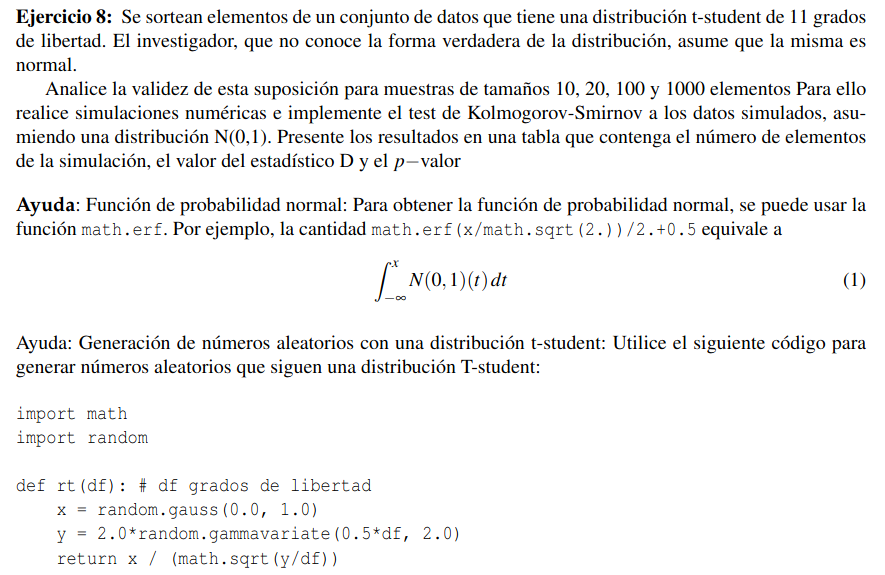

  Tamaño |  D manual |  p manual |   D scipy |   p scipy
--------------------------------------------------------
      10 |    0.3437 |    0.1499 |    0.3437 |    0.1474
      20 |    0.1610 |    0.6167 |    0.1610 |    0.6211
     100 |    0.1127 |    0.1404 |    0.1127 |    0.1457
    1000 |    0.0968 |    0.0000 |    0.0968 |    0.0000


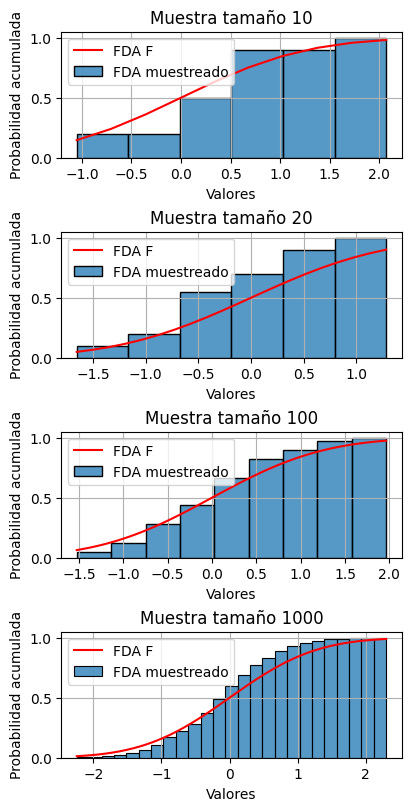

In [39]:
from numpy import sqrt, log, linspace, inf
from random import random, seed, gammavariate, gauss
from scipy.stats import kstest
from scipy.special import erf
import seaborn as sns
import matplotlib.pyplot as plt

N_SIM = 10_000
TAMANOS = [10, 20, 100, 1000]

def tstudent():
    grados_libertad=11
    x = gauss(0.0, 1.0)
    y = 2.0*gammavariate(0.5*grados_libertad, 2.0)
    return x / (sqrt(y/grados_libertad))

def tstudent_muestreador(n):
    return [tstudent() for i in range(n)]

def Normal_rechazo(mu, sigma):
    while True:
        Y1 = -log(1 - random())
        Y2 = -log(1 - random())
        if Y2 >=(Y1-1) ** 2 / 2:
            if random() < 0.5:
                return Y1 * sigma + mu
            return -Y1 * sigma + mu

def F_fda(x):
    return erf(x/sqrt(2)) / 2 + 0.5

def F_muestreador(n):
    return [Normal_rechazo(mu=0, sigma=1) for _ in range(n)]

def estadistico_KS(muestra, F_fda):
    tamano_muestra = len(muestra)
    muestra_ordenada = sorted(muestra)
    D_max =  -inf

    for j, y in enumerate(muestra_ordenada, start=1):
        F_y = F_fda(y)
        D_minus = F_y - (j - 1) / tamano_muestra
        D_plus = j / tamano_muestra - F_y
        D_max = max(D_max, D_minus, D_plus)

    return D_max

def estimar_Pvalor_KS(muestra_empirica):
    tamano_muestra = len(muestra_empirica)
    d_empirico = estadistico_KS(muestra_empirica, F_fda)
    cuenta = 0
    for _ in range(N_SIM):

        F_muestra = F_muestreador(tamano_muestra)
        d_simulado = estadistico_KS(F_muestra, F_fda)

        # U_muestra = [random() for _ in range(tamano_muestra)]
        # d_simulado = estadistico_KS(U_muestra, lambda x: x)

        if d_empirico <= d_simulado:
            cuenta += 1
    return cuenta / N_SIM


seed(1)
muestras_tstudent = [tstudent_muestreador(tam) for tam in TAMANOS]

p_valores = [estimar_Pvalor_KS(muestra) for muestra in muestras_tstudent]
d_estadisticos = [estadistico_KS(muestra, F_fda) for muestra in muestras_tstudent]

resultados_scipy = [kstest(muestra, cdf=F_fda) for muestra in muestras_tstudent]
d_correctos, p_valores_correctos = zip(*[(r.statistic, r.pvalue) for r in resultados_scipy])

# Cantidad de muestras
num_graficos = len(TAMANOS)

# Creamos figura y ejes con filas y columnas
fig, axes = plt.subplots(nrows=num_graficos, ncols=1, figsize=(4, 2 * num_graficos), constrained_layout=True)


# Mostrar tabla formateada
print(f"{'Tamaño':>8} | {'D manual':>9} | {'p manual':>9} | {'D scipy':>9} | {'p scipy':>9}")
print("-" * 56)
for i, (n, d_m, p_m, d_s, p_s, muestra) in enumerate(
    zip(TAMANOS, d_estadisticos, p_valores, d_correctos, p_valores_correctos, muestras_tstudent)
):
    print(f"{n:8} | {d_m:9.4f} | {p_m:9.4f} | {d_s:9.4f} | {p_s:9.4f}")
    dom = linspace(min(muestra), max(muestra), num=n)
    ax = axes[i] if num_graficos > 1 else axes  # Para caso 1 solo eje

    sns.lineplot(x=dom, y=F_fda(dom), ax=ax, label="FDA F", color="red")
    sns.histplot(muestra, stat="density", cumulative=True, ax=ax, label="FDA muestreado")

    ax.set_title(f"Muestra tamaño {n}")
    ax.set_xlabel("Valores")
    ax.set_ylabel("Probabilidad acumulada")
    ax.legend()
    ax.grid(True)

plt.show()